# Proyecto #1
### Yosef Maldonado - 14003689

In [4]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
# loading dataset
'''
SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
OverallQual: Overall material and finish quality, rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
       
1stFlrSF: First Floor square feet
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
YearBuilt: Original construction date
LotFrontage: Linear feet of street connected to property
'''

dataset = np.load('./data/proyecto_training_data.npy')

In [38]:
# creating dataframe to label columns
column_labels = ['SalePrice', 'OverallQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage']
df = pd.DataFrame(dataset, columns=column_labels)

In [39]:
# slicing dataset
df_rows = df.shape[0]
split_index = int(df_rows * 0.80)  # check where to split
df_training_set = df.iloc[:split_index] # 80% of the data
df_validation_and_test_set = df.iloc[split_index:] # 20% of the data

# Análisis exploratorio de datos (Training set)

In [40]:
# training (80% of dataset) analysis
# DataFrame.describe(): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html#pandas.DataFrame.describe
# Transpose (T): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html
df_training_statistics = df_training_set.describe().T 
df_training_statistics['range'] = df_training_statistics['max'] - df_training_statistics['min'] # range
df_training_statistics = df_training_statistics[['mean', 'max', 'min', 'range', 'std']]
df_training_statistics

,mean,max,min,range,std
SalePrice,180590.277397,755000.0,34900.0,720100.0,78815.697902
OverallQual,6.101027,10.0,1.0,9.0,1.378025
1stFlrSF,1156.323630,3228.0,334.0,2894.0,373.780374
TotRmsAbvGrd,6.485445,14.0,2.0,12.0,1.609141
YearBuilt,1971.451199,2010.0,1875.0,135.0,29.951707
LotFrontage,69.946985,313.0,21.0,292.0,23.478161


# Histograma de variable (Training set)

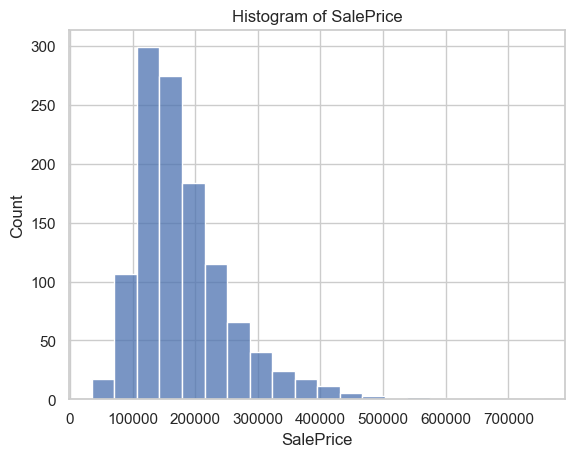

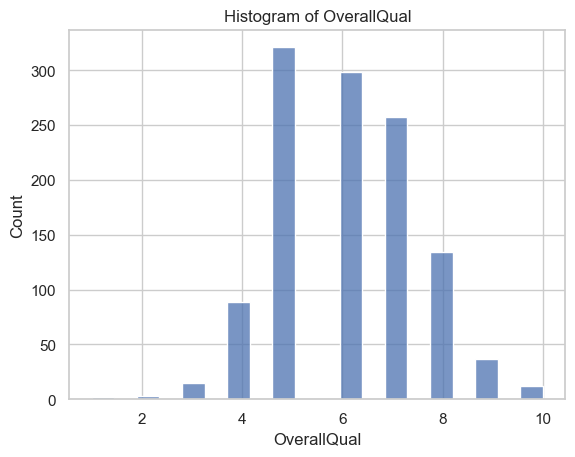

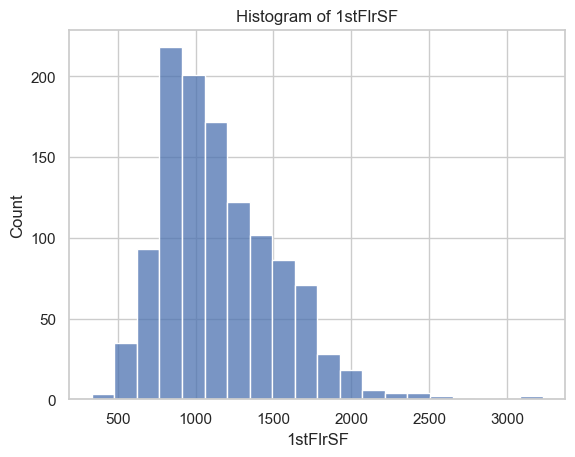

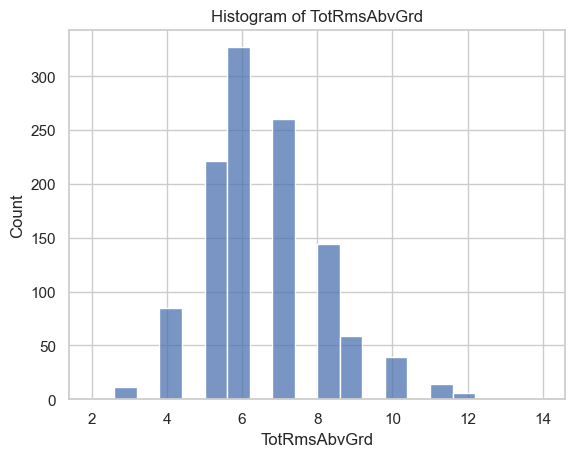

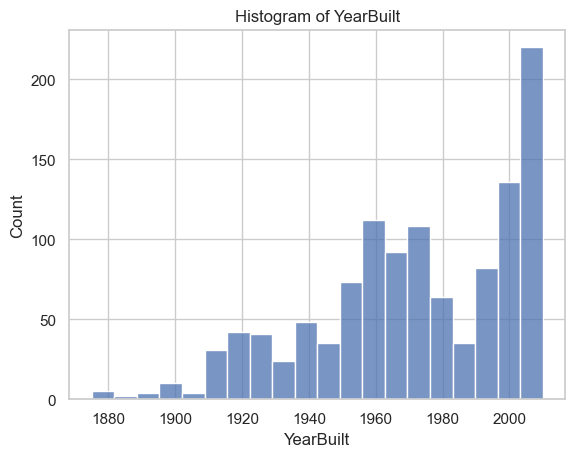

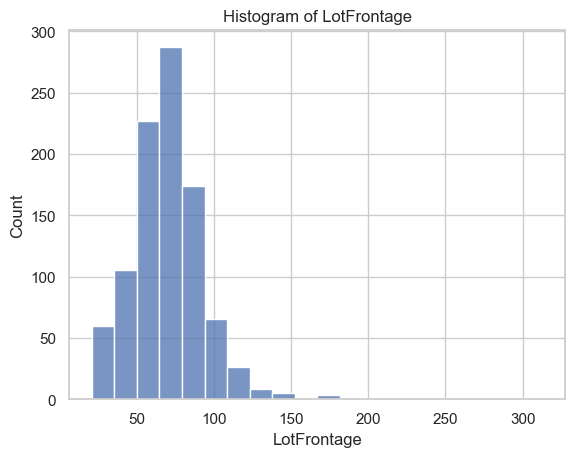

In [45]:
# distplot is deprecated: https://seaborn.pydata.org/generated/seaborn.distplot.html
# using histplot

sns.set(style='whitegrid')

for column in df_training_set.columns:
    sns.histplot(df_training_set[column].dropna(), kde=False, bins=20)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()


# Correlación con variables independientes (Training set)

In [76]:
# SalePrice: "This is the target variable that you're trying to predict" (Dependant variable)
# getting correlations
df_training_correlation_matrix = df_training_set.corr()
df_training_correlation_matrix = df_training_correlation_matrix['SalePrice'].drop('SalePrice')
# convert series to data frame for easier manipulation
df_training_correlation = pd.DataFrame(df_training_correlation_matrix).reset_index()
df_training_correlation.columns = ['Variable', 'Correlation with SalePrice']
# sort by the absolute value of the correlation, descending order (creating temporal column)
df_training_correlation['Absolute Correlation'] = df_training_correlation['Correlation with SalePrice'].abs()
df_training_correlation = df_training_correlation.sort_values(by='Absolute Correlation', ascending=False).drop('Absolute Correlation', axis=1) # removing temporary column
# format the correlation values for better readability
df_training_correlation['Correlation with SalePrice'] = df_training_correlation['Correlation with SalePrice'].apply(lambda x: f'{x:.3f}')
# display the sorted and formatted data frame
df_training_correlation

,Variable,Correlation with SalePrice
0,OverallQual,0.794
1,1stFlrSF,0.616
2,TotRmsAbvGrd,0.565
3,YearBuilt,0.534
4,LotFrontage,0.363


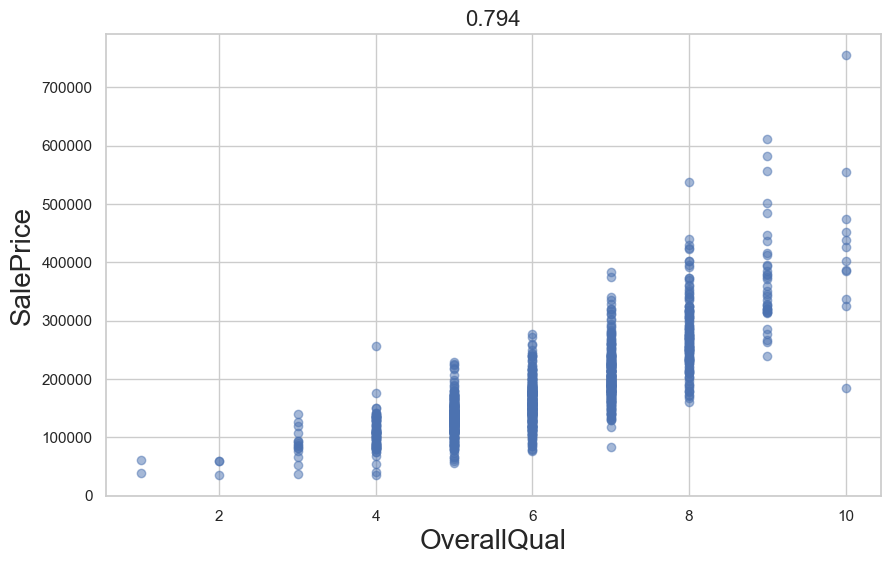

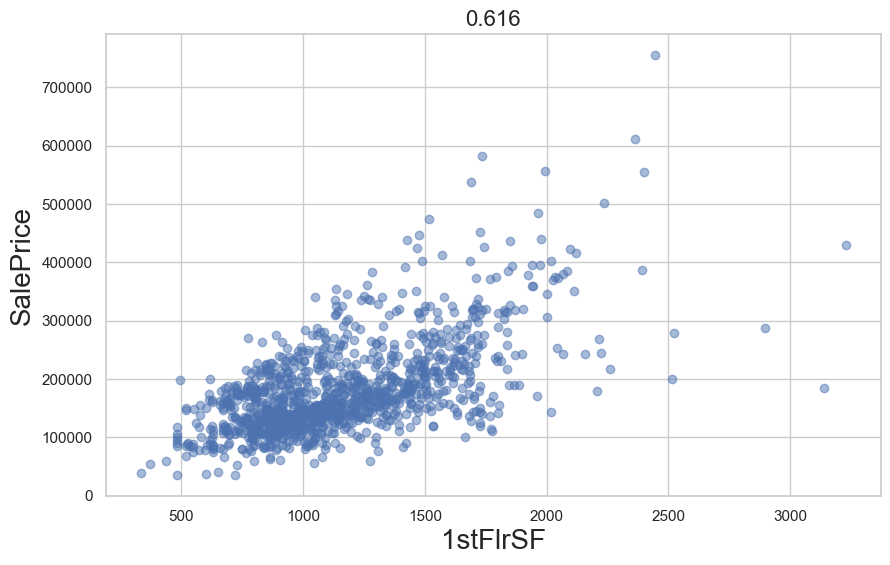

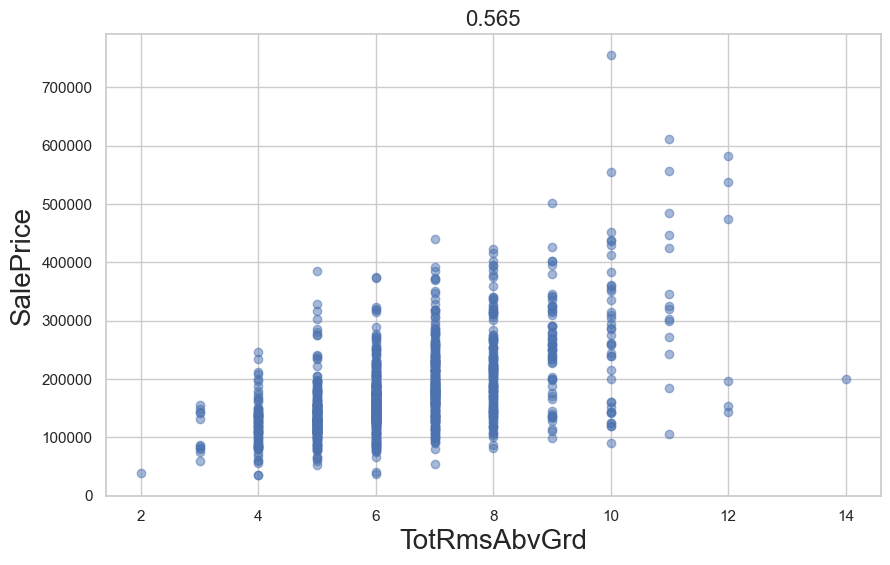

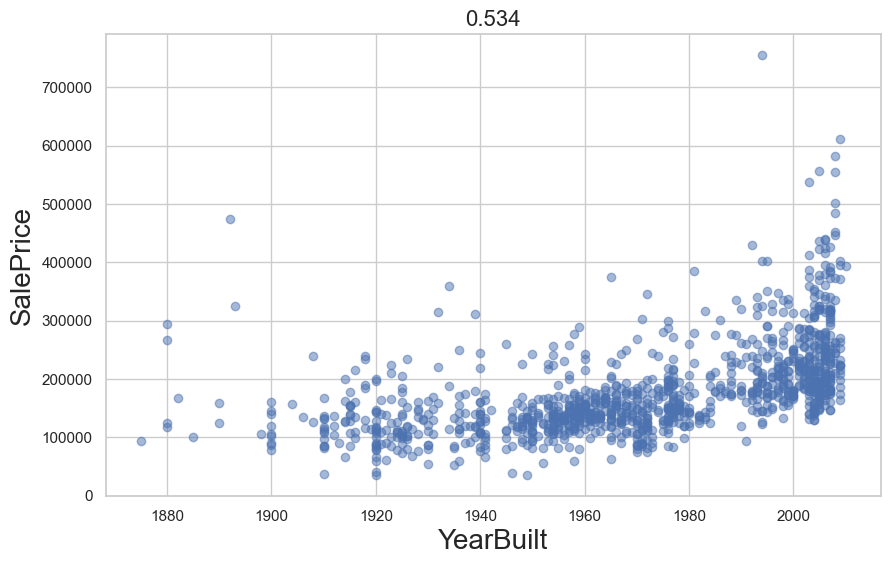

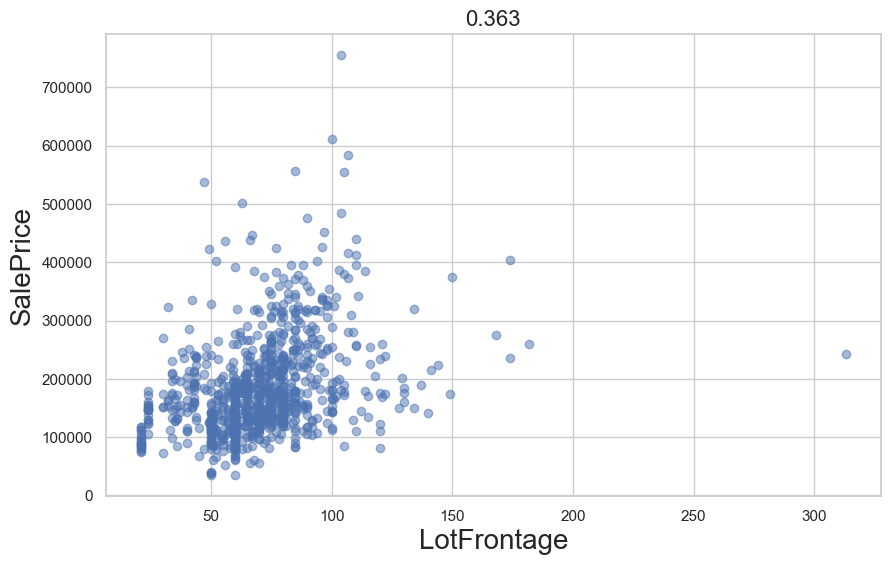

In [77]:
# base on df_training_correlation results
for index, row in df_training_correlation.iterrows():
    variable = row['Variable']
    correlation = row['Correlation with SalePrice']
    plt.figure(figsize=(10, 6))
    plt.scatter(df_training_set[variable], df_training_set['SalePrice'], alpha=0.5)  # plot scatter
    plt.title(correlation, fontsize=16) # correlation value as title
    plt.xlabel(variable, fontsize=20)  # x-axis label
    plt.ylabel('SalePrice', fontsize=20)  # y-axis label
    plt.grid(True)  # adding grid
    plt.show()
    print("\n" * 4)


In [84]:
# variables with more correlation
df_training_correlation.head(2)

,Variable,Correlation with SalePrice
0,OverallQual,0.794
1,1stFlrSF,0.616


# Función para entrenar modelo de regresión lineal

In [24]:
class LinealRegressionStep:
    def __init__(self, vect_x, vect_y, observations, beta_start, prediction, error, beta_update):
        for name, value in locals().items():
            if name != "self":
                setattr(self, name, value)

In [27]:
# vec_x = Vector with the independent variable x,
# vec_y = Vector with the dependent variable y,
# epochs = An integer that indicates how many iterations to train the model for.
# print_error_every = An integer which tells us after how many iterations we want to print via print: the iteration number, the model's error in that iteration. If "print_error_every" = 10, the error is displayed on screen for the iterations: 10, 20, 30, 40, 50.
# learning_rate = Scalar α (learning rate): is used as part of the mathematical expression to update the model parameters in each iteration.

def lineal_reg(vect_x, vect_y, epochs, print_error_every, learning_rate=0.01):
    # steps
    lineal_regression_steps = []
    # arrays
    vect_x = np.array(vect_x)
    vect_y = np.array(vect_y)
    # error array
    errors = []
    # sanity check
    if vect_x.shape[0] != vect_y.shape[0]:
        raise ValueError('The input vectors vect_x and vect_y must have the same length.')
    # setting up observations for vector operations
    observations = np.column_stack((vect_x, np.ones(vect_x.shape[0])))
    # initializing β0 and β1
    beta = np.random.rand(2).reshape(2, 1) * 0.01  # using starting values in the range of [0,0.01)
    # for each epoch:
    for epoch in range(epochs):
        # get prediction with vector operation
        prediction = np.dot(observations, beta)
        # get error
        error = (1 / (2 * len(vect_y))) * np.sum((vect_y.reshape(-1, 1) - prediction) ** 2)
        errors.append(error)
        # gradient errors calculation, using matrix multiplication
        gradient_errors = (1 / len(vect_y)) * np.dot(observations.T, (prediction - vect_y.reshape(-1, 1)))
        # updating beta
        beta_start = beta
        beta -= learning_rate * gradient_errors
        # print error every 'print_error_every' epochs
        if print_error_every and (epoch + 1) % print_error_every == 0:
            print(f'Epoch {epoch + 1}, Error: {error}')
        lineal_regression_steps.append(LinealRegressionStep(vect_x, vect_y, observations, beta_start, prediction, error, beta))
    return lineal_regression_steps, errors

# test
steps, error_history = lineal_reg(np.arange(20, 25, 1), np.arange(10, 15, 1), 100, 0, 0.01)
print(error_history)
    

    

[71.53474112669407, 1068.4521207232992, 15998.86737527328, 239605.45797533763, 3588467.9281569943, 53742981.77031413, 804886177.745023, 12054443947.053612, 180534369856.24036, 2703787818254.648, 40493500334428.61, 606454233673171.9, 9082611641439510.0, 1.360264792440542e+17, 2.0372117388694733e+18, 3.0510468932606677e+19, 4.569425439321998e+20, 6.843437539961524e+21, 1.0249130439975745e+23, 1.5349694384180502e+24, 2.2988595868460812e+25, 3.442905941815131e+26, 5.156296361905455e+27, 7.722369597405362e+28, 1.156547025487362e+30, 1.7321121519657464e+31, 2.5941119910131944e+32, 3.88509312995774e+33, 5.818541636110908e+34, 8.714186671639574e+35, 1.3050873242343385e+37, 1.954574750412913e+38, 2.927284928763681e+39, 4.384072316680012e+40, 6.565841913447595e+41, 9.833387069908541e+42, 1.472705291131073e+44, 2.2056091752580936e+45, 3.303248696992509e+46, 4.947137542128639e+47, 7.409121173050479e+48, 1.1096331179287341e+50, 1.661851152985393e+51, 2.4888850288048564e+52, 3.7274991057297167e+53, 